# **Social Distancing Detection using YOLO v3**

---

## **1. Business Objectives**

In the fight against the Covid-19 pandemic, social distancing, contactless meetings, wearing mask all are proven to be very effective measure to slow down the spread of the virus. social distancing is the one of the best way to prevent from virus. people asked to keep distance of at least 6 feetform other to stop the spread of a virus.

Social distancing, also called physical distancing, is a measures intended to prevent the spread of a contagious disease by maintaining a physical distance between people.

In this project, the objecctive is to build an Object Detection System to detect persons and calculate the distance between them and detect social distance violations.

## **2. Data Collection**

The data was taken from google for testing.

We would be using the available libraries like OpenCV and pre-trained Object Detection model like YOLO v3.

In [ ]:
# Mounting the drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Importing some libraries

import numpy as np
import matplotlib.pyplot as plt

import imutils
import os
import time
import math
from itertools import chain 

import cv2
from google.colab.patches import cv2_imshow

from scipy.spatial import distance as dist
import argparse

np.random.seed(42)

## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [ ]:
# Path for the YOLO v3 weights, cgf and coco.names file

YOLOV3_LABELS_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/coco.names'
YOLOV3_CFG_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/yolov3.cfg'
YOLOV3_WEIGHTS_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/yolov3.weights'

In [ ]:
# Initializing minimum probability to filter weak detections along with the threshold when applying non-maxima suppression
MIN_CONF = 0.3
NMS_THRESH = 0.3

# Defining the minimum safe distance (in pixels) that two people can be from each other
MIN_DISTANCE = 1.5

In [ ]:
# Extracting the labels from Yolo v3 label file
LABELS = open(YOLOV3_LABELS_PATH).read().strip().split('\n')

# Randomly assigning colour index for all the labels
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype='uint8')

In [ ]:
# Checking the labels that Yolo v3 can detect

print("The no. of Labels in the YOLO v3 is : ", len(LABELS))
print("The Labels in the YOLO v3 is : ", LABELS)

The no. of Labels in the YOLO v3 is :  80
The Labels in the YOLO v3 is :  ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
print('Loading YOLO from disk...')

# Loading the Yolo v3 pre-trained weights on COCO Dataset
neural_net = cv2.dnn.readNetFromDarknet(YOLOV3_CFG_PATH, YOLOV3_WEIGHTS_PATH)

# Extracting all the layers of Yolo v3
layer_names = neural_net.getLayerNames()

# Extracting unconnected layers
layer_names = [layer_names[i[0] - 1] for i in neural_net.getUnconnectedOutLayers()]

print("Done.")

Loading YOLO from disk...
Done.


In [ ]:
print("The Unconnected layer names : ", layer_names)

The Unconnected layer names :  ['yolo_82', 'yolo_94', 'yolo_106']


## **4. Model Building**

Since we have loaded the pre-trained models, we can proceed to build the social distance measurement tool.

In [ ]:
# Function to detect person in the images and return the detected bboxes

def Detect_Person_In_Image_Frame(frame, neural_net, ln, personIdx=0):
    
    # Setting up the Width and Height from the framess captured from the input feed
    H, W = (frame.shape[0], frame.shape[1])
    results = []

    # Construct a blob from the input frame, scaling and resizing it
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

    # Performing a forward pass of the YOLO object detector
    neural_net.setInput(blob)

    # Extracting bounding boxes and associated probabilities
    start_time = time.time()
    layer_outputs = neural_net.forward(ln)
    end_time = time.time()
    
    # Initializing the lists for detected bbox, confidences, classes and box centroid
    boxes = []
    confidences = []
    classIDs = []
    lines = []
    box_centers = []

    # Iterating over each of the layer outputs
    for output in layer_outputs:
        # Iterating over each of the object detected in the image frame
        for detection in output:
            # Extract the class ID and confidence (i.e., probability) of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filtering detections by ensuring that the object detected was a person(classID = 0) and 
            # the minimum confidence is met            
            if confidence > MIN_CONF and classID == personIdx:
                # Scale the bbox coordinates back relative to the size of the image 
                # Since YOLO returns the center (x, y) - coordinates of the bbox 
                # followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype('int')
                
                # Using the center (x, y) - coordinates to derive the top left corner of the bbox
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                
                # Updating the list of bbox coordinates, centroids, and confidences
                box_centers.append((centerX, centerY))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # Apply non-maxima suppression to suppress weak, overlapping bboxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONF, NMS_THRESH)

    # Ensuring atleast one detection exists
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():

          # Extract the bbox coordinates
          (x, y) = (boxes[i][0], boxes[i][1])
          (w, h) = (boxes[i][2], boxes[i][3])

          # Update the results list that consists of the person
          # prediction probability, bbox coordinates, and the centroid
          r = (confidences[i], (x, y, x + w, y + h), box_centers[i])
          results.append(r)

	  # Return the list of results
    return results

In [ ]:
def Detect_Social_Distancing_Violations(frame=None, writer=None, OUTPUT_PATH="", INPUT_IS_VIDEO=False, vs=None):

    print("Detecting Social Distance Violations...")
    print("Capturing Video..")
    while True:
        if INPUT_IS_VIDEO:
            # Reading the next frame from the file
            (grabbed, frame) = vs.read()
            # If the frame was not grabbed, then we have reached the end of the stream
            if not grabbed:
                print("Video Frames processed.")
                break        
        # Resizing the frame and then detect people (person class) in it
        height, width = frame.shape[0], frame.shape[1]
        pixel_per_m = (width - 150) / 7
        results = Detect_Person_In_Image_Frame(frame, neural_net, layer_names, personIdx = LABELS.index("person"))

        # Initialize the set of indexes of person bbox that violate the minimum social distance
        violate = set()
        pair_violation = {}

        # Ensure there are atleast two people detections (required in order to compute our pairwise distance maps)
        if len(results) >= 2:
            # Extract all centroids from the results
            centroids = np.array([r[2] for r in results])
            # Computing the Euclidean distances between all pairs of the centroids
            D = dist.cdist(centroids, centroids, metric="euclidean")
            D = D / pixel_per_m
            # Iterating over the upper triangular of the distance matrix
            for i in range(0, D.shape[0]):
                for j in range(i + 1, D.shape[1]):
                    # Check to see if the distance between any two centroid pairs is less than the configured number of pixels
                    if D[i, j] < MIN_DISTANCE:
                      # Update our violation set with the indexes of the centroid pairs
                      violate.add(i)
                      violate.add(j)
                      if i in pair_violation.keys():
                          pair_violation[i].append((j, D[i, j]))
                      else:
                          pair_violation[i] = []
                          pair_violation[i].append((j, D[i, j]))

        # Iterate over the results
        for (i, (prob, bbox, centroid)) in enumerate(results):
            # Extract the bbox and centroid coordinates, then initialize the colour of the annotation
            (startX, startY, endX, endY) = bbox
            (cX, cY) = centroid
            # Colouring Green
            color = (0, 255, 0)
            # If the index exists within the violation set, then update the colour
            if i in violate:
                # Coloring Red
                color = (255, 0, 0)
            # Draw bbox around the detected person
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            # Draw centroid coordinates of the person
            cv2.circle(frame, (cX, cY), 5, color, 1)

            if i in pair_violation.keys():
                for violators_tuple in pair_violation[i]:
                    ob = violators_tuple[0]
                    end_person = results[ob]
                    end_perosn_centroid = end_person[2]
                    cv2.line(frame, (cX, cY), end_perosn_centroid , [255, 0, 0], 2) 

        # Draw the total number of social distancing violations on the output frame
        text = "Social Distancing Violations : {}".format(len(violate))
        cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Saving the video or image to drive
        if INPUT_IS_VIDEO:
            # If an output video file path has been supplied and the video writer has not been initialized, do so now
            if OUTPUT_PATH != "" and writer is None:
                # Initialize our video writer
                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                writer = cv2.VideoWriter(OUTPUT_PATH, fourcc, 25, (frame.shape[1], frame.shape[0]), True)
                print("Writing the video to drive.")

            # If the video writer is not None, write the frame to the output video file
            if writer is not None:
                writer.write(frame)
        else:
            cv2.imwrite(OUTPUT_PATH, frame)
            print("Done..")
            break

## **5. Testing the System**

Now, we can try to test the system with video and image samples.

In [ ]:
# Path for Video path and Output Path
VIDEO_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/video.mp4'
OUTPUT_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/output.mp4'

# Video Capture object to load the video
vs = cv2.VideoCapture(VIDEO_PATH)

# Calculating the number of frames using CAP_PROP_FRAME_COUNT of OpenCV
try:
    if(imutils.is_cv2()):
        prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT
    else:
        prop = cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("Total frames detected are : ", total)
except Exception as e:
    print(e)
    total = -1

Detect_Social_Distancing_Violations(None, None, OUTPUT_PATH, True, vs)
print("Done..")

Total frames detected are :  584
Detecting Social Distance Violations...
Capturing Video..
Writing the video to drive.
Video Frames processed.
Done..


In [ ]:
# Path for Video path and Output Path
VIDEO_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/pedestrians.mp4'
OUTPUT_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/pedestrians_output.mp4'

# Video Capture object to load the video
vs = cv2.VideoCapture(VIDEO_PATH)

# Calculating the number of frames using CAP_PROP_FRAME_COUNT of OpenCV
try:
    if(imutils.is_cv2()):
        prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT
    else:
        prop = cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("Total frames detected are : ", total)
except Exception as e:
    print(e)
    total = -1

Detect_Social_Distancing_Violations(None, None, OUTPUT_PATH, True, vs)
print("Done..")

Total frames detected are :  531
Detecting Social Distance Violations...
Capturing Video..
Writing the video to drive.
Video Frames processed.
Done..


In [ ]:
# Path for Image path and Output Path
IMG_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/image.jpg'
OUTPUT_PATH = '/content/drive/MyDrive/Colab Datasets/Social DIstancing Detection/annotated_image.png'

image = cv2.imread(IMG_PATH) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
Detect_Social_Distancing_Violations(image, None, OUTPUT_PATH, False, None)

Detecting Social Distance Violations...
Done..


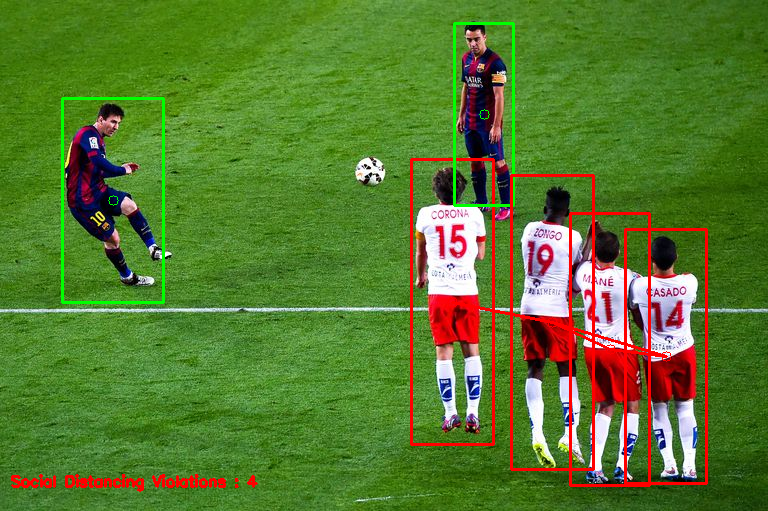

In [ ]:
# Checking the Image after annotations

image_2 = cv2.imread(OUTPUT_PATH) 
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
cv2_imshow(image_2)

## **6. Conclusion**

We were able to build a Social Distancing System using OpenCV and YoLo v3 model. Even though it works fairly well, a lot of space is available for improvement. The fps is fairly low in this project but we can increase it using other SOTA techniques.

Future Scope:

Although this project is cool, it has a few limitations,
  - This project does not take into account the camera perspective.
  - It does not leverage a proper camera calibration (Distances are not measure accurate).
  - We can use other SOTA models like SSD, SSDLite to get better fps rendering.